In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import os
import json
from itertools import permutations
from sklearn.decomposition import PCA
import umap.umap_ as umap

np.random.seed(42)

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

/opt/anaconda3/envs/periscope_2022_updated/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/anaconda3/envs/periscope_2022_updated/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/anaconda3/envs/periscope_2022_updated/lib/python3.9

In [2]:
# Set data input folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)
if not os.path.exists(os.path.join(output_folder,"figure_panels")):
    os.makedirs(os.path.join(output_folder,"figure_panels"), exist_ok=True)

In [3]:
# Import the A549 gene-level profiles
df_gene = pd.read_csv("../Profile_Aggregation/outputs/20200805_A549_WG_Screen_guide_normalized_feature_select_median_merged_ALLBATCHES___CP186___ALLWELLS_gene_aggregated.csv.gz").set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')

# Import annotated gene sets
with open("../common_files/annotated_gene_sets.json") as f:
    gene_set_dict = json.load(f)

# Load CORUM data
CORUM_data = pd.read_csv(f'../common_files/CORUM_humanComplexes.txt',sep = '\t')
# Load STRING data
STRING_data = pd.read_csv('../common_files/STRING_data.csv.gz')

# Load p_values from the hit calling process
df_p_values = pd.read_csv('../Hit_Calling/outputs/A549_significant_features_mann_whitney_p_values.csv.gz')
df_p_values = df_p_values.set_index('Gene')

# Load expression data 
with open("../Hit_Calling/outputs/A549_CCLE_expression_summary.json") as f:
    express = json.load(f)
    zero_tpm_list = express['zero_tpm']
    expressed_gene_list = express['expressed_genes']


# Figure 2A and 2B

In [4]:
# Extract the features
features = df_p_values.columns.to_list()
mito_list = [feature for feature in features if 'mito'  in feature.lower()]
cona_list = [feature for feature in features if 'cona'  in feature.lower()]
dapi_list = [feature for feature in features if 'dapi'  in feature.lower()]
wga_list = [feature for feature in features if 'wga'  in feature.lower()]
phalloidin_list = [feature for feature in features if 'phalloidin'  in feature.lower()]
print('Number of features per compartment: ','\n',
      'Mito features: ',len(mito_list),'\n',
      'ConA features: ',len(cona_list),'\n',
      'DAPI features: ',len(dapi_list),'\n',
      'WGA features: ',len(wga_list),'\n',
      'Phalloidin features: ',len(phalloidin_list))

Number of features per compartment:  
 Mito features:  346 
 ConA features:  221 
 DAPI features:  321 
 WGA features:  285 
 Phalloidin features:  254


In [5]:
# Quantification of number of significant features per compartment at a certain p-value
p_value = 0.001
gene_list = list(df_p_values.index)

df_sig_feature = pd.DataFrame(index=gene_list)
for gene in gene_list:
    # Count Mito features 
    mito_c = 0 
    for feat in mito_list:
        if df_p_values.loc[gene,feat] < p_value:
            mito_c += 1 
    # Count ConA features 
    cona_c = 0 
    for feat in cona_list:
        if df_p_values.loc[gene,feat] < p_value:
            cona_c += 1 
    # Count WGA features 
    wga_c = 0 
    for feat in wga_list:
        if df_p_values.loc[gene,feat] < p_value:
            wga_c += 1 
    # Count DAPI features 
    dapi_c = 0 
    for feat in dapi_list:
        if df_p_values.loc[gene,feat] < p_value:
            dapi_c += 1 
    # Count WGA features 
    phal_c = 0 
    for feat in phalloidin_list:
        if df_p_values.loc[gene,feat] < p_value:
            phal_c += 1 
    # Count all features
    sum_c = 0
    for feat in features:
        if df_p_values.loc[gene,feat] < p_value:
            sum_c += 1 
            
    df_sig_feature.loc[gene,'Mito'] = mito_c
    df_sig_feature.loc[gene,'ConA'] = cona_c
    df_sig_feature.loc[gene,'WGA'] = wga_c
    df_sig_feature.loc[gene,'DAPI'] = dapi_c
    df_sig_feature.loc[gene,'Phalloidin'] = phal_c
    df_sig_feature.loc[gene,'Sum'] = sum_c
    
df_sig_feature.head()

,Mito,ConA,WGA,DAPI,Phalloidin,Sum
A1BG,12.0,15.0,18.0,25.0,17.0,88.0
A1CF,12.0,9.0,16.0,18.0,27.0,89.0
A2M,21.0,13.0,11.0,49.0,20.0,124.0
A2ML1,15.0,13.0,12.0,23.0,14.0,81.0
A3GALT2,32.0,13.0,17.0,37.0,17.0,115.0


In [6]:
# Perturbations divided into 2 groups of controls with 0 TPM and others
df_sig_feature_zero_tpm = df_sig_feature.loc[zero_tpm_list]
df_sig_feature_expressed = df_sig_feature.loc[expressed_gene_list]
df_sig_feature_zero_tpm.head()

,Mito,ConA,WGA,DAPI,Phalloidin,Sum
A2M,21.0,13.0,11.0,49.0,20.0,124.0
A3GALT2,32.0,13.0,17.0,37.0,17.0,115.0
AADACL2,19.0,12.0,11.0,15.0,13.0,71.0
AADACL3,13.0,9.0,13.0,14.0,15.0,67.0
AADACL4,11.0,12.0,16.0,17.0,16.0,78.0


In [7]:
# Function for false discovery rate (FDR) calculation

def FDR_1(control_sig_feature):
    total = len(control_sig_feature)
    FDR_1 = int(total/100)
    mito_1, cona_1, wga_1, dapi_1, phal_1, sum_1 = 0,0,0,0,0,0
    channels = ['Mito','ConA','WGA','DAPI','Phalloidin']
    c = 200
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('Mito > @c'))
        mito_1 = c + 1
        c-=1    
    
    c = 200
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('ConA > @c'))
        cona_1 = c + 1
        c-=1     
        
    c = 200
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('WGA > @c'))
        wga_1 = c + 1
        c-=1    
    
    c = 200
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('DAPI > @c'))
        dapi_1 = c + 1
        c-=1    
    
    c = 200
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('Phalloidin > @c'))
        phal_1 = c + 1
        c-=1    
        
    c = 500
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('Sum > @c'))
        sum_1 = c + 1
        c-=1    
    
    return mito_1, cona_1, wga_1, dapi_1, phal_1, sum_1


In [8]:
# Compute and print the threshold for FDR calculations at 5% from the 0 TPM gene perturbations
mito_1, cona_1, wga_1, dapi_1, phal_1,sum_1 = FDR_1(df_sig_feature_zero_tpm)
print('Mito genes', mito_1, '\n', 
      'ConA genes', cona_1, '\n', 
      'WGA genes', wga_1, '\n', 
      'DAPI genes', dapi_1, '\n', 
      'Phalloidin genes', phal_1, '\n',
      'Whole Profile genes', sum_1)

Mito genes 49 
 ConA genes 37 
 WGA genes 57 
 DAPI genes 78 
 Phalloidin genes 48 
 Whole Profile genes 217


In [9]:
# Save the number of significant features per channel for whole cell hits and compartment hits
A549_whole_cell_hits = df_sig_feature_expressed.query('Sum > @sum_1')
A549_comp_spec_hits = df_sig_feature_expressed.query('Sum <= @sum_1').query('Phalloidin > @phal_1 | DAPI > @dapi_1 | WGA > @wga_1 | ConA > @cona_1 | Mito > @mito_1')
A549_whole_cell_hits.reset_index().rename(columns={'index':'Gene'}).to_csv(os.path.join(output_folder,'A549_plate_level_median_per_feat_sig_genes_1_FDR_whole_cell_hits.csv'),index=False)
A549_comp_spec_hits.reset_index().rename(columns={'index':'Gene'}).to_csv(os.path.join(output_folder,'A549_plate_level_median_per_feat_sig_genes_1_FDR_compartment_specific_hits.csv'),index=False)
A549_whole_cell_hits.head()

,Mito,ConA,WGA,DAPI,Phalloidin,Sum
ABCB7,32.0,20.0,26.0,108.0,20.0,222.0
ABCF1,35.0,23.0,34.0,65.0,71.0,225.0
ACTB,40.0,22.0,59.0,40.0,80.0,240.0
AP1G2,37.0,22.0,57.0,44.0,50.0,224.0
AP2M1,41.0,25.0,102.0,61.0,16.0,246.0


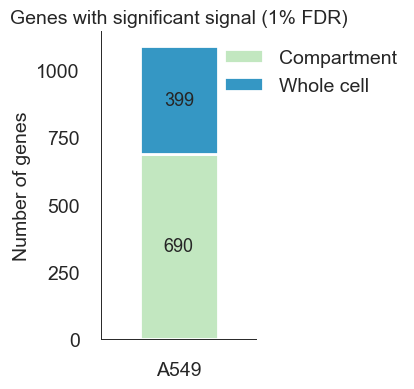

In [10]:
# Plot hits summary for Fig 2A
A549_whole_cell = len(df_sig_feature_expressed.query('Sum > @sum_1'))
A549_comp_spec = len(df_sig_feature_expressed.query('Sum <= @sum_1').query('Phalloidin > @phal_1 | DAPI > @dapi_1 | WGA > @wga_1 | ConA > @cona_1 | Mito > @mito_1'))

mpl.rc('axes', linewidth=0.7)
mpl.rc('xtick', labelsize=14)
mpl.rc('xtick', labelsize=14)

fig, ax = plt.subplots( figsize=(2,4))
colors = sns.color_palette('GnBu')[:8]
hits_plot = pd.DataFrame({'Compartment': [A549_comp_spec],
                         'Whole cell': [A549_whole_cell] },
                        index=['A549'])

hits_plot.plot(kind='bar', 
               stacked=True,
               color=[colors[1], colors[4]],
               legend = 'reverse',
               rot = 0,
               fontsize= 14,
               width = 0.5,
               ax=ax)

ax.set_title('Genes with significant signal (1% FDR)',size=14)
ax.set_ylabel('Number of genes',size=14)

ax.bar_label(ax.containers[0],label_type='center',size=13)
ax.bar_label(ax.containers[1],label_type='center',size=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc="upper left", bbox_to_anchor=(0.68,1),frameon=False, ncol=1, fontsize =14)
fig.savefig(os.path.join(output_folder,'figure_panels','Fig2A_A549_whole_cell_compartment_specific_hits.png'),dpi = 300,bbox_inches='tight')

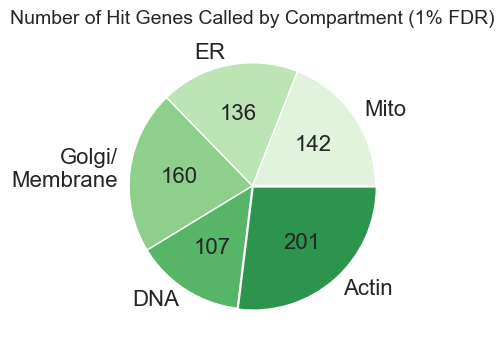

In [11]:
# Plot hits summary for Fig 2B
def absolute_value2(val):
    a  = data[np.abs(data - val/100.*sum(data)).argmin() ]
    return a

labels = ['Mito','ER','Golgi/\nMembrane','DNA','Actin']
data = [len(df_sig_feature_expressed.query('Mito > @mito_1 & Sum <= @sum_1')),
        len(df_sig_feature_expressed.query('ConA > @cona_1 & Sum <= @sum_1')),
        len(df_sig_feature_expressed.query('WGA > @wga_1 & Sum <= @sum_1')),
        len(df_sig_feature_expressed.query('DAPI > @dapi_1 & Sum <= @sum_1')),
        len(df_sig_feature_expressed.query('Phalloidin > @phal_1 & Sum <= @sum_1'))]

colors = sns.color_palette('Greens')[:5]
               
fig, ax = plt.subplots(figsize=(7,4))

sns.set_theme(style='white',palette='RdBu')
plt.pie(data,
        labels=labels,
        autopct=absolute_value2,
        colors=colors,
        textprops={'fontsize': 16},
        explode=(0.0, 0.0, 0.0, 0.0, 0.01))
ax.set_title('Number of Hit Genes Called by Compartment (1% FDR)',size=14)
fig.savefig(os.path.join(output_folder,'figure_panels','Fig2B_A549_compartment_specific_hits_distribution.png'),dpi = 300,bbox_inches='tight')

# Figure 2C

In [12]:
# Directly load hit lists to bypass running Fig2A/B
#A549_whole_cell_hits = pd.read_csv(os.path.join(output_folder,'A549_plate_level_median_per_feat_sig_genes_1_FDR_whole_cell_hits.csv')).set_index('Gene')
#A549_comp_spec_hits = pd.read_csv(os.path.join(output_folder,'A549_plate_level_median_per_feat_sig_genes_1_FDR_compartment_specific_hits.csv')).set_index('Gene')

In [13]:
hit_list = list(A549_comp_spec_hits.index) + list(A549_whole_cell_hits.index)
df_hits = df_gene.loc[df_gene.index.isin(hit_list)]
df_hits.head()

,Cells_AreaShape_CentralMoment_0_1,Cells_AreaShape_CentralMoment_0_3,Cells_AreaShape_CentralMoment_1_0,Cells_AreaShape_CentralMoment_1_2,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_HuMoment_1,Cells_AreaShape_HuMoment_6,Cells_AreaShape_NormalizedMoment_0_2,...,Nuclei_Texture_SumVariance_ConA_5_01_256,Nuclei_Texture_SumVariance_DAPI_Painting_10_01_256,Nuclei_Texture_SumVariance_DAPI_Painting_10_03_256,Nuclei_Texture_SumVariance_Mito_5_01_256,Nuclei_Texture_SumVariance_Phalloidin_10_01_256,Nuclei_Texture_SumVariance_Phalloidin_10_03_256,Nuclei_Texture_SumVariance_Phalloidin_5_01_256,Nuclei_Texture_SumVariance_WGA_10_01_256,Nuclei_Texture_SumVariance_WGA_10_03_256,Nuclei_Texture_SumVariance_WGA_5_03_256
Metadata_Foci_Barcode_MatchedTo_GeneCode,,,,,,,,,,,,,,,,,,,,,
AAMP,0.076100,0.001463,-0.011151,0.029308,0.329480,-0.012306,-0.162878,-0.102137,0.003059,-0.361455,...,-0.050787,-0.744528,-0.314682,-0.038622,0.044990,0.196703,0.170772,-0.232923,-0.317620,-0.132316
ABCA10,-0.069417,-0.014072,0.021129,0.033220,-0.568477,-0.279770,0.097710,-0.343380,0.003075,-0.360150,...,-0.110005,0.065378,-0.055860,0.014066,-0.181387,-0.136961,-0.151564,-0.095560,-0.082625,-0.165130
ABCB7,0.076353,0.011840,0.032775,-0.025006,0.194614,0.078878,-0.157764,-0.174020,0.002899,-0.028420,...,-0.249350,-0.265110,-0.337555,-0.049632,-0.056051,-0.150475,-0.039870,-0.098050,-0.185540,-0.188420
ABCB9,0.012099,-0.042516,-0.022622,0.005458,0.045621,0.120146,-0.035066,-0.268005,0.002906,-0.362510,...,-0.323125,-0.330085,-0.439915,-0.068935,-0.199155,-0.247070,-0.148420,-0.149045,-0.237065,-0.123869
ABCF1,0.005656,0.002842,0.052795,-0.019022,0.436745,-0.146703,0.093430,0.115299,0.002900,0.142850,...,-0.211770,0.451039,0.367385,0.064120,0.013437,0.110100,-0.053282,-0.092426,-0.115030,0.010564


In [14]:
# Perform principal component analysis on hit list
pca = PCA()
pca.fit(df_hits)
x = list(pca.explained_variance_ratio_)
# Find principal component that represents 90% variation
PCA_lookup = {}
for i in range(len(x)):
    distance = abs(.9-sum(x[:i+1]))
    PCA_lookup[distance] = i 
component = PCA_lookup[min(PCA_lookup.keys())]+1
print (f'Principal component representing closest to 90% variation is {component}')
# Perform principal component analysis and select components representing 90% of variation in data
pca = PCA(n_components=component)
df_hits_pca = pd.DataFrame(pca.fit_transform(df_hits),index=df_hits.index)
df_hits_pca.head()

Principal component representing closest to 90% variation is 334


,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
Metadata_Foci_Barcode_MatchedTo_GeneCode,,,,,,,,,,,,,,,,,,,,,
AAMP,3.046438,4.666673,-2.588992,2.777750,2.114535,-3.772484,1.710590,1.735848,0.538685,-0.015838,...,0.354297,0.048902,0.028625,0.283948,-0.093100,0.016069,-0.321157,0.313275,-0.091610,0.004392
ABCA10,5.450895,-3.198494,1.231338,-2.601427,-0.091416,-1.330733,-1.791968,-1.312457,0.413101,-0.079322,...,0.049666,-0.071254,0.178416,-0.128036,-0.063900,-0.309850,0.262601,0.018658,0.255454,-0.243841
ABCB7,-1.924528,-3.029201,2.963113,0.101669,0.810169,0.419894,0.462151,0.104112,0.525497,0.176585,...,-0.057137,-0.111111,0.118342,0.161348,-0.027052,0.062760,-0.111250,-0.027284,-0.073892,0.259741
ABCB9,-2.268469,-1.899819,1.651165,0.523574,-0.897654,0.163934,0.861157,0.586109,0.401294,-0.690440,...,0.106173,0.011568,-0.025804,-0.007038,0.265378,0.201750,-0.162325,-0.048633,-0.129827,0.049246
ABCF1,5.922611,8.454385,-1.634317,0.680219,1.127582,0.972265,-2.055622,0.114975,0.052827,1.065508,...,-0.236392,-0.125704,0.004510,0.020643,0.144195,0.095767,-0.255390,0.052534,-0.030413,-0.264160


In [15]:
# Calculate correlation between all gene pairs and create a dictionary of gene pairs/correlation
df_hits_corr = df_hits_pca.T.corr()
genes = list(df_hits_corr.index)
corr_dic = {}
for gene1 in genes:
    for gene2 in genes:
        if len(frozenset([gene1,gene2])) == 1 :
            continue
        else:    
            corr_dic[frozenset([gene1,gene2])]=(df_hits_corr.loc[gene1,gene2])
        
print(f'Gene pair correlation dictionary contains {len(corr_dic)} entries')


Gene pair correlation dictionary contains 592416 entries


In [16]:
# Create a list of protein clusters with all complexes that had at least 66% of genes represented within the A549 WGS hits
cluster_count = 0
hit_cluster_list_list = []
hit_set = set()
for i in range(len(CORUM_data)):
    cluster = CORUM_data.iloc[i]['subunits(Gene name)'].split(';')
    count = 0
    hit_cluster_list = []
    for g in cluster:
        if g in genes:
            count += 1
            hit_set.add(g)
            hit_cluster_list.append(g)
    if (count/len(cluster)) > 0.333:
        cluster_count += 1
    if hit_cluster_list and (count/len(cluster)) > 0.333:
        hit_cluster_list_list.append(hit_cluster_list)
print(f'There are {len(hit_set)} unique genes within the cluster')
print(f'There are {cluster_count} clusters within the hit genes with at least 1/3 overlap with a CORUM cluster')
print(f'There are {len(hit_cluster_list_list)} duplicates within the list')

There are 464 unique genes within the cluster
There are 645 clusters within the hit genes with at least 1/3 overlap with a CORUM cluster
There are 645 duplicates within the list


In [17]:
# Assign correlations to hit gene pairs
hit_pair_set = set()
for l in hit_cluster_list_list:
    for c in list(permutations(l,2)):
        hit_pair_set.add(frozenset(c))

hit_corr_dic = {}
for s in hit_pair_set:
    if len(s) != 1:
        hit_corr_dic[s] = corr_dic[s]

print(f'There are {len(hit_pair_set)} hit pairs.')
print(f'There are {len(hit_corr_dic)} hit pairs with correlation.')

There are 972 hit pairs.
There are 972 hit pairs with correlation.


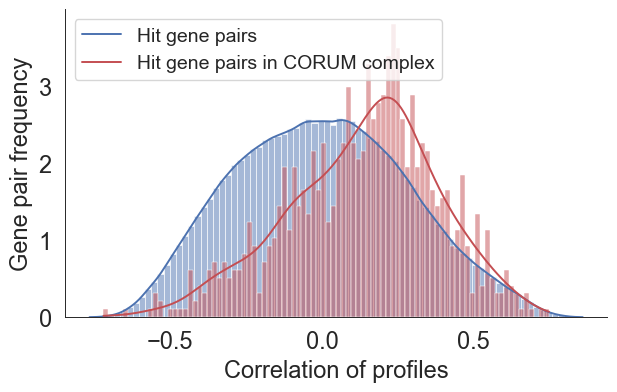

In [18]:
# Plot CORUM gene pair correlation distribution
sns.set_theme(style="white",rc = {'axes.linewidth': 0.7,'xtick.labelsize':17,'ytick.labelsize':17})

fig, ax = plt.subplots(figsize=(7,4))
a = list(corr_dic.values())
b = list(hit_corr_dic.values())

sns.histplot(a ,color='b' ,stat= 'percent' ,bins= 80, kde=True, line_kws={'lw':1.4} , alpha=0.5,ax = ax);
sns.histplot(b ,color='r' ,stat= 'percent' ,bins= 90, kde=True, line_kws={'lw':1.4} ,alpha=0.5,ax = ax);

ax.set_ylabel('Gene pair frequency',size=17)
ax.set_xlabel('Correlation of profiles',size=17)
font = font_manager.FontProperties(size=14)
ax.legend(['Hit gene pairs','Hit gene pairs in CORUM complex'],loc='upper left',prop=font )
sns.despine(top = True)

fig.savefig(os.path.join(output_folder,'figure_panels','Fig2C_A549_CORUM_gene_pair_correlation_distribution.png'), dpi=300,facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

In [19]:
# Calculate the median values for correlations for background gene pairs and gene pairs in CORUM clusters 
print("Background gene pair profile correlation median",np.median(list(corr_dic.values())))
print("Gene pairs in CORUM clusters profile correlation median",np.median(list(hit_corr_dic.values())))

Background gene pair profile correlation median -0.004083448118054916
Gene pairs in CORUM clusters profile correlation median 0.16170784437776645


# Figure 2D

In [20]:
# Subset the STRING predicted protein links to A549 hits
STRING_data_hits = STRING_data[STRING_data['protein1'].isin(genes) & STRING_data['protein2'].isin(genes)]
print(f'Full PPI database is {len(STRING_data)} entries')
print(f'PPI database subsetted to A549 hits is {len(STRING_data_hits)} entries')
corr_min = min(corr_dic.values())
corr_max = max(corr_dic.values())   
print(f'Minimum correlation is {corr_min}')
print(f'Maximum correlation is {corr_max}')

Full PPI database is 11938498 entries
PPI database subsetted to A549 hits is 87880 entries
Minimum correlation is -0.7661285222280442
Maximum correlation is 0.859284831297906


In [21]:
# Bin the correlations into 8 categories 
results = STRING_data_hits.copy(deep=True).reset_index(drop=True)

bins = [-1,-0.66,-0.33,0,0.33,0.66,1]
for i in range(len(results)):
    gene1 = results.iloc[i]['protein1']
    gene2 = results.iloc[i]['protein2']
    corr_value = corr_dic[frozenset([gene1,gene2])]
    results.at[i , 'correlation'] = corr_value
    if corr_value > bins[5]:
        results.at[i , 'correlation_bin'] = f'{bins[5]} to {bins[6]}'
    elif corr_value > bins[4] and corr_value <= bins[5]:
        results.at[i , 'correlation_bin'] = f'{bins[4]} to {bins[5]}'
    elif corr_value > bins[3] and corr_value <= bins[4]:
        results.at[i , 'correlation_bin'] = f'{bins[3]} to {bins[4]}'
    elif corr_value > bins[2] and corr_value <= bins[3]:
        results.at[i , 'correlation_bin'] = f'{bins[2]} to {bins[3]}'
    elif corr_value > bins[1] and corr_value <= bins[2]:
        results.at[i , 'correlation_bin'] = f'{bins[1]} to {bins[2]}'
    elif corr_value <= bins[1]:
        results.at[i , 'correlation_bin'] = f'{bins[0]} to {bins[1]}'
results.head()

,protein1,protein2,combined_score,correlation,correlation_bin
0,SCTR,GPR146,209,-0.220074,-0.33 to 0
1,SCTR,PTHLH,509,0.568633,0.33 to 0.66
2,SCTR,FFAR1,264,-0.309660,-0.33 to 0
3,SCTR,TM7SF3,193,0.503107,0.33 to 0.66
4,SCTR,BTF3,169,0.115436,0 to 0.33


/var/folders/pm/r5xv70_14yx_b9gflxr4xck40000gp/T/ipykernel_97251/1697678606.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(round(float(label))) for label in labels], size=16)


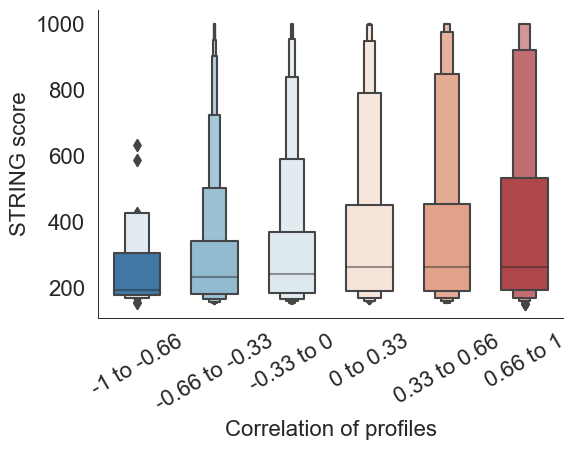

In [22]:
# Plot STRING score x gene pair correlation
sns.set_theme(style="white",rc = {'axes.linewidth': 0.7})

fig, ax = plt.subplots(figsize=(6,4))
order = [f'{bins[0]} to {bins[1]}',f'{bins[1]} to {bins[2]}',f'{bins[2]} to {bins[3]}',f'{bins[3]} to {bins[4]}',f'{bins[4]} to {bins[5]}',f'{bins[5]} to {bins[6]}']

flierprops = dict(markerfacecolor='white', markersize=0.1, linestyle='none')
sns.boxenplot(data=results,
            x = 'correlation_bin',
            y = 'combined_score',
            order=order, 
            width = 0.6,
            palette = 'RdBu_r',
            ax=ax)

ax.set_xlabel('Correlation of profiles',size=16)
ax.set_ylabel('STRING score',size=16)
ax.tick_params(axis='both', which='major', labelsize=14)
labels = [item for item in ax.get_yticks()]
ax.set_yticklabels([str(round(float(label))) for label in labels], size=16)
ax.set_xticklabels(order, size=16,rotation=30)
sns.despine(top = True,left=False,bottom=False)

fig.savefig(os.path.join(output_folder,'figure_panels','Fig2D_A549_STRING_gene_pair_correlation_score.png'), 
            dpi=300,
            facecolor='w', 
            edgecolor='w', 
            bbox_inches='tight')
plt.show()

# Figure 2E

In [23]:
# Perform UMAP dimentionality reduction to project data into a 2-dimensional plane 
clusterable_embedding = umap.UMAP(
    n_neighbors=3,
    min_dist=0.04,
    n_components=2,
    random_state=43,
    metric = 'cosine',
).fit_transform(df_hits_pca)

In [24]:
# Manually label highlighted hits
whole_cell_hit_list = list(A549_whole_cell_hits.index)
overall_labels = [list(df_hits_pca.index).index(i) if i in whole_cell_hit_list else -1 for i in hit_list ]
other_labels = [list(df_hits_pca.index).index(i) if i not in whole_cell_hit_list else -1 for i in hit_list ]
highlight_categories = ['RIBONUCLEOPROTEIN_COMPLEX','GLYCOSYLATION','PROTEASOMAL_PROTEIN_CATABOLIC_PROCESS','PROCESS_UTILIZING_AUTOPHAGIC_MECHANISM','MITOCHONDRIAL_ENVELOPE','RRNA_METABOLIC_PROCESS','MRNA_PROCESSING','MITOTIC_CELL_CYCLE','NCRNA_METABOLIC_PROCESS','TRANSFERASE_COMPLEX']
highlight_list = []
for x in highlight_categories:
    highlight_list += gene_set_dict[x]
highlight_labels = [list(df_hits_pca.index).index(i) if i in highlight_list else -1 for i in hit_list ]
len(overall_labels)-other_labels.count(-1)

690

In [25]:
'''
# Save the coordinates/additional information from the UMAP
condition = 'A549'
clusterable_embedding_x, clusterable_embedding_y = np.split(clusterable_embedding,2,axis=1)
clusterable_embedding_x_list = clusterable_embedding_x.tolist()
clusterable_embedding_y_list = clusterable_embedding_y.tolist()
umap_dic = {
    f'{condition}_overall_labels':(overall_labels),
    f'{condition}_other_labels':(other_labels),
    f'{condition}_highlight_labels':(highlight_labels),
    f'{condition}_clusterable_embedding_x':(clusterable_embedding_x_list),
    f'{condition}_clusterable_embedding_y':(clusterable_embedding_y_list),
    f'{condition}_gene_names':(list(df_hits_pca.index))
}
umap_json = json.dumps(umap_dic)

with open(f"outputs/{condition}_umap_frozen_version.json", "w") as f:
    f.write(umap_json)
'''

'\n# Save the coordinates/additional information from the UMAP\ncondition = \'A549\'\nclusterable_embedding_x, clusterable_embedding_y = np.split(clusterable_embedding,2,axis=1)\nclusterable_embedding_x_list = clusterable_embedding_x.tolist()\nclusterable_embedding_y_list = clusterable_embedding_y.tolist()\numap_dic = {\n    f\'{condition}_overall_labels\':(overall_labels),\n    f\'{condition}_other_labels\':(other_labels),\n    f\'{condition}_highlight_labels\':(highlight_labels),\n    f\'{condition}_clusterable_embedding_x\':(clusterable_embedding_x_list),\n    f\'{condition}_clusterable_embedding_y\':(clusterable_embedding_y_list),\n    f\'{condition}_gene_names\':(list(df_hits_pca.index))\n}\numap_json = json.dumps(umap_dic)\n\nwith open(f"outputs/{condition}_umap_frozen_version.json", "w") as f:\n    f.write(umap_json)\n'

In [26]:
# Load the frozen version of the UMAP data from the paper figure
with open("outputs/A549_umap_frozen_version.json") as f:
    umap_json = json.load(f)
    
clusterable_embedding_x_list = umap_json['A549_clusterable_embedding_x']
clusterable_embedding_y_list = umap_json['A549_clusterable_embedding_y']
clusterable_embedding_x = np.asanyarray(clusterable_embedding_x_list,dtype='float32')
clusterable_embedding_y = np.asanyarray(clusterable_embedding_y_list,dtype='float32')
clusterable_embedding = np.column_stack((clusterable_embedding_x, clusterable_embedding_y))
overall_labels = umap_json['A549_overall_labels']
other_labels = umap_json['A549_other_labels']
highlight_labels = umap_json['A549_highlight_labels']
gene_names_with_order = umap_json['A549_gene_names']

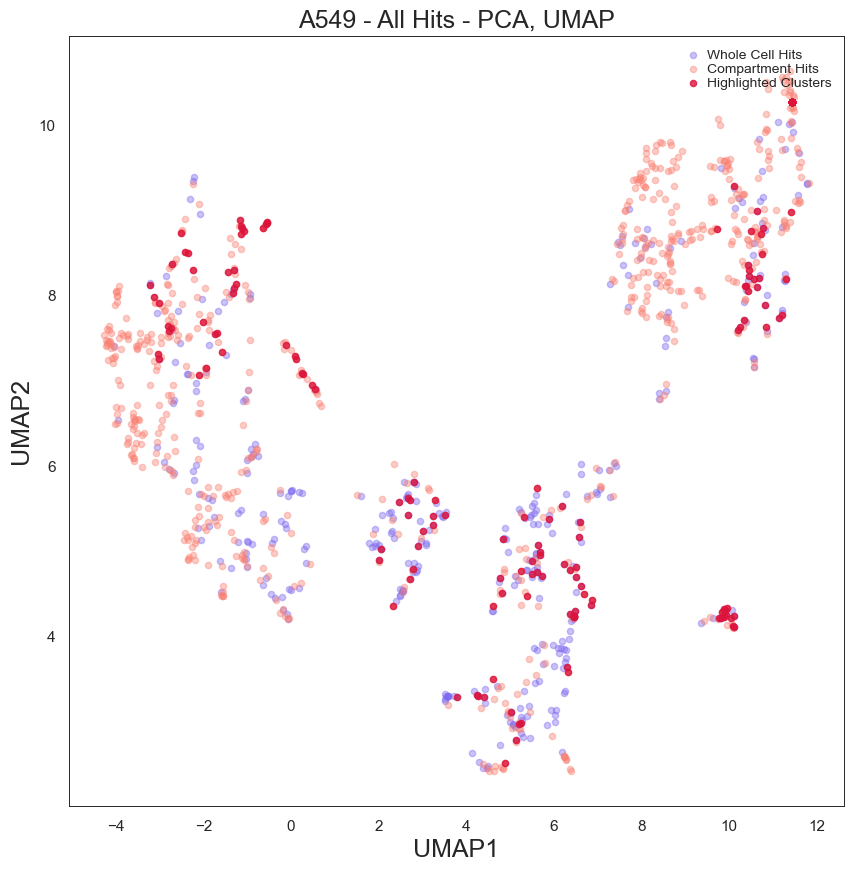

In [27]:
# Plot the data and color code based on the type of hit.
plt.figure(figsize=(10, 10))

plt.scatter(clusterable_embedding[overall_labels, 0],
            clusterable_embedding[overall_labels, 1],
            c='mediumslateblue',
            s=20,
            alpha=0.4,
           );

plt.scatter(clusterable_embedding[other_labels, 0],
            clusterable_embedding[other_labels, 1],
            c='salmon',
            s=20,
            alpha=0.4,
           );

plt.scatter(clusterable_embedding[highlight_labels, 0],
            clusterable_embedding[highlight_labels, 1],
            c='crimson',
            s=20,
            alpha=0.8,
           );

plt.title('A549 - All Hits - PCA, UMAP',fontsize=18)
plt.xlabel('UMAP1',fontsize=18)
plt.ylabel('UMAP2',fontsize=18)
plt.legend(labels=['Whole Cell Hits','Compartment Hits','Highlighted Clusters'],loc="upper right",bbox_to_anchor=(1,1), frameon=False, ncol=1,fontsize=10 ,labelspacing=0.1,handletextpad=0)

plt.savefig(os.path.join(output_folder,'figure_panels','Fig2E_A549_UMAP_clustering.png'),bbox_inches='tight', dpi=600,facecolor='w', edgecolor='w')

# Figure 2F and 2G

In [28]:
# Perform principal component analysis on gene level profiles
pca = PCA()
pca.fit(df_gene)
x = list(pca.explained_variance_ratio_)
# Find principal component that represents 70% variation
PCA_lookup = {}
for i in range(len(x)):
    distance = abs(.7-sum(x[:i+1]))
    PCA_lookup[distance] = i 
component = PCA_lookup[min(PCA_lookup.keys())]+1
print (f'Principal component representing closest to 70% variation is {component}')

# Perform principal component analysis and select components representing 70% of variation in data
pca = PCA(n_components=component)
df_gene_pca = pd.DataFrame(pca.fit_transform(df_gene),index=df_gene.index)
df_gene_pca.head()

Principal component representing closest to 70% variation is 253


,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
Metadata_Foci_Barcode_MatchedTo_GeneCode,,,,,,,,,,,,,,,,,,,,,
A1BG,-1.380499,1.943896,1.041290,-1.058325,0.485686,-0.079396,-0.881773,0.326539,2.041482,0.638002,...,-0.211930,0.289673,-0.220647,-0.270162,-0.180551,0.065851,0.201713,-0.100190,0.080842,-0.117500
A1CF,2.232154,1.000573,2.071821,0.230564,-1.079317,-3.416486,1.203544,0.096978,-0.038421,-0.980009,...,0.397465,0.027786,-0.058456,-0.043761,0.000415,0.553932,-0.100166,0.292166,-0.036817,-0.125899
A2M,-1.567411,-0.917117,-2.583937,-0.778576,-1.977611,-1.671850,1.341665,-0.938053,0.943137,-0.624144,...,-0.110363,-0.159422,-0.084524,-0.029478,0.085465,0.254758,-0.047869,-0.041290,0.219168,0.199822
A2ML1,0.457439,-0.901825,-1.079235,-1.718810,0.200263,0.090491,0.308747,-0.516008,-0.264989,0.583996,...,-0.092864,0.478344,0.091091,0.114386,-0.047069,-0.194404,0.027719,0.147758,0.018485,-0.234920
A3GALT2,-1.920922,-0.291265,-0.706640,3.144675,0.640857,-0.916184,1.259547,0.522542,-0.041706,0.355432,...,-0.267311,-0.209457,-0.032576,-0.105187,-0.509178,-0.085032,-0.483231,-0.083603,0.019532,0.486663


In [29]:
# Calculate correlations, cluster and draw heatmap 
def clustered_heat_map(data,file_name,font_scale=0.8,linewidth=1):
        corr = data.corr()
        sns.set(font_scale=font_scale)

        g = sns.clustermap(
            corr, 
            vmin=-1, vmax=1, center=0,
            method = 'ward',
            figsize = (30 ,30),
            cmap=sns.diverging_palette(250, 10 ,s=100,l=35, n=100),
            linewidth = linewidth,
            linecolor='white',
            cbar=False,
            cbar_kws={"shrink": .76},
        )
        ax = g.ax_heatmap
        ax.set_xlabel("")
        ax.set_ylabel("")
        g.ax_row_dendrogram.set_visible(False)
        g.ax_col_dendrogram.set_visible(False)
        g.cax.set_visible(False)
        plt.tight_layout()
        output_file = os.path.join(f"{file_name}")
        plt.savefig(output_file,dpi=300) 
        plt.show()


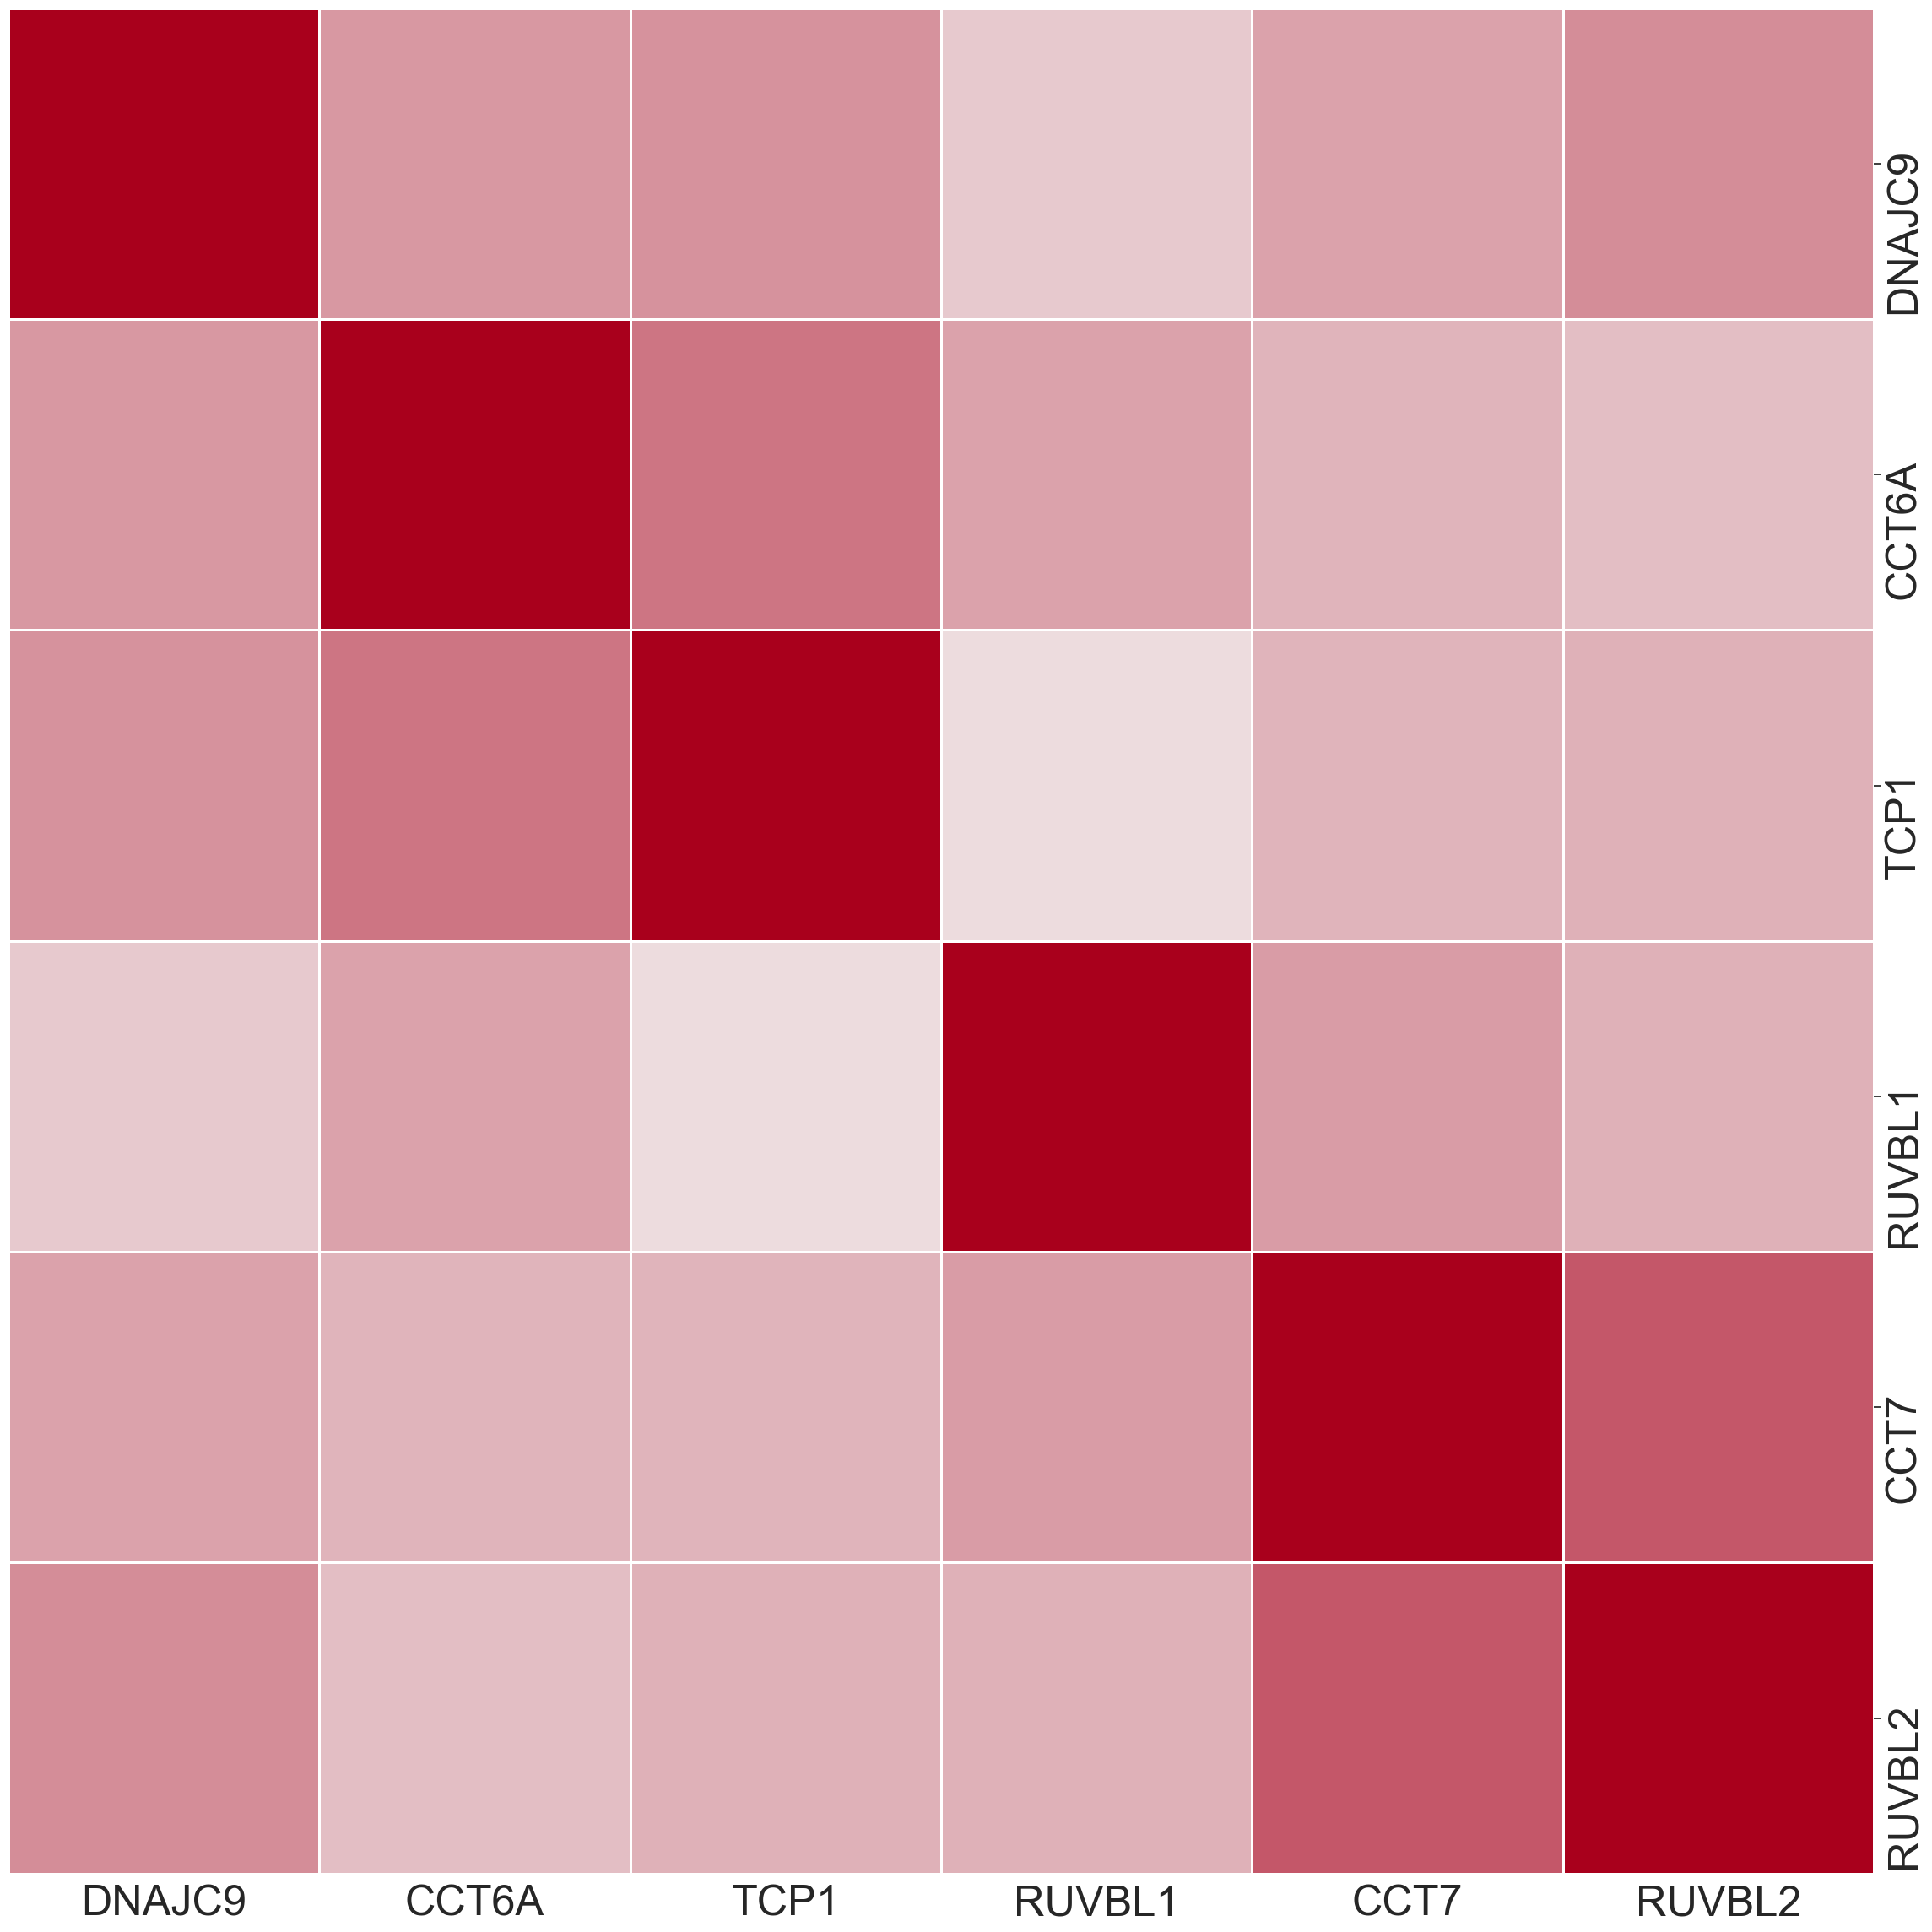

In [30]:
# Subset the gene set, calculate correlations, cluster and draw the heatmap
gene_set = 'Chaperone Complex'
genes_list = gene_set_dict[gene_set]
genes_list = [i for i in genes_list if i in hit_list]
genes_df =  df_gene_pca.loc[df_gene_pca.index.isin(genes_list)]

clustered_heat_map(genes_df.T,
                   os.path.join(output_folder,'figure_panels',f'Fig2F_{gene_set}_heat_map.png'),
                   3.3)


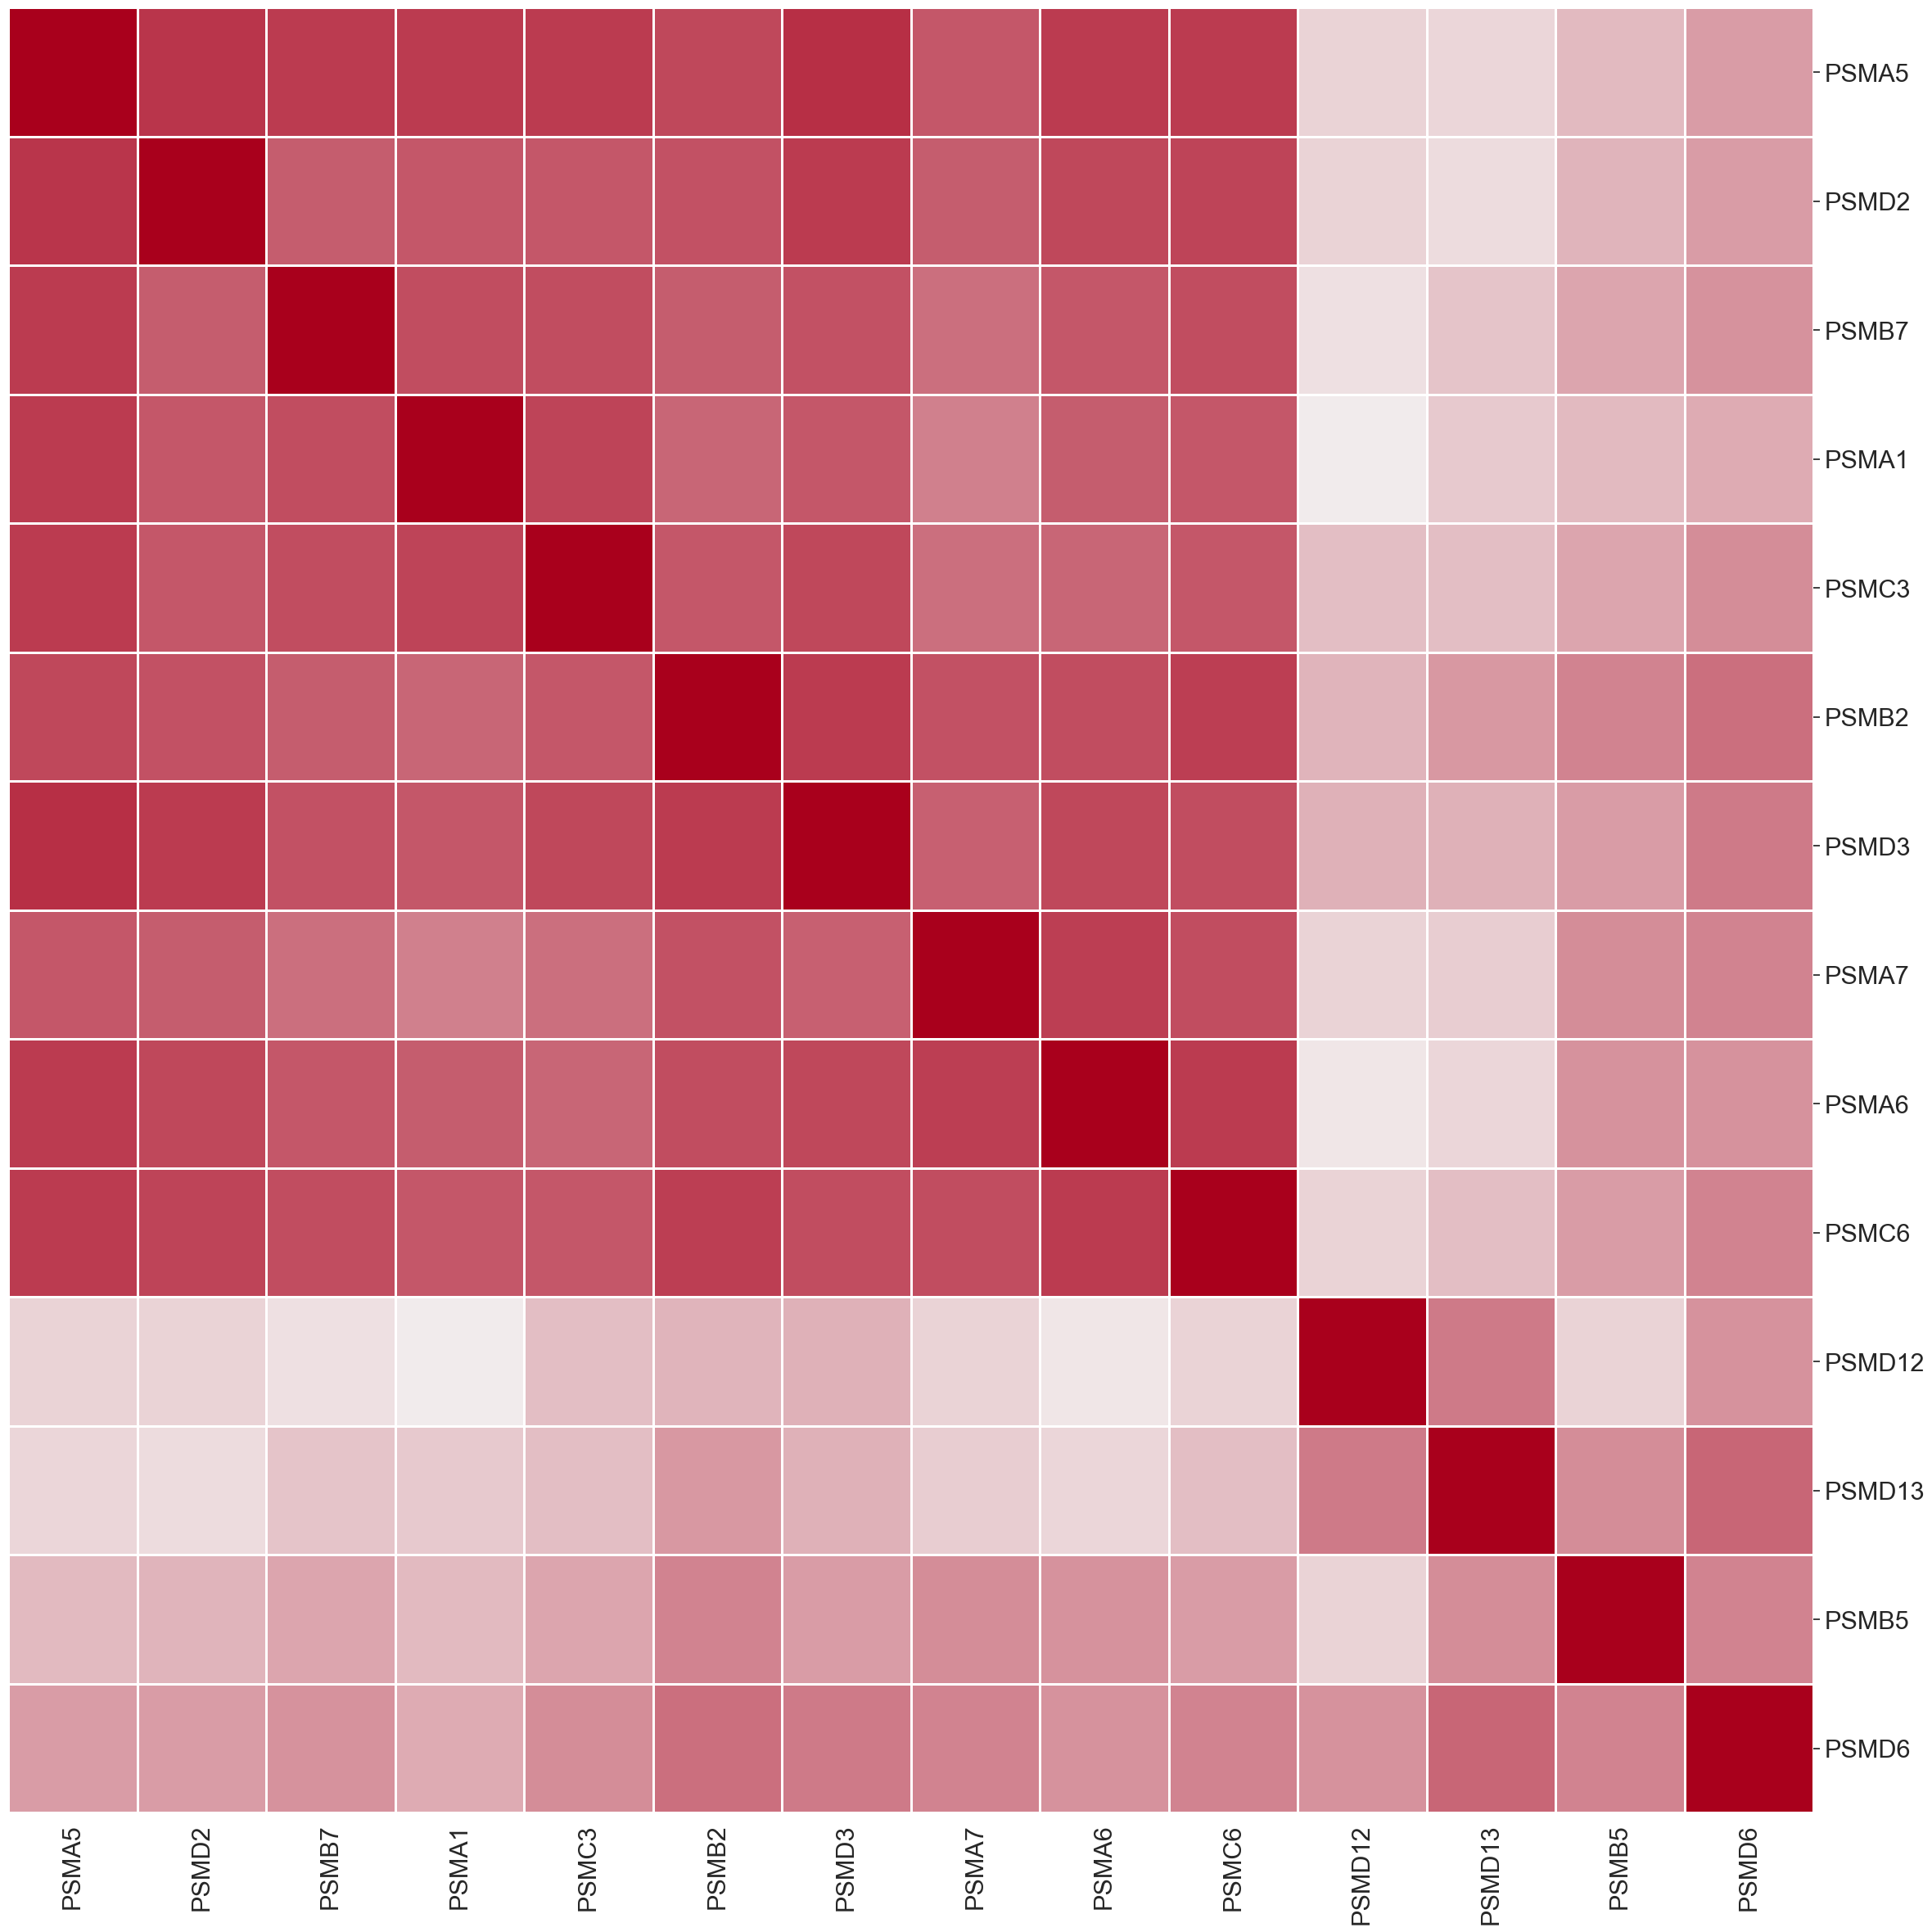

In [31]:
# Subset the geneset, calculate correlations, cluster and draw the heatmap
gene_set = 'Proteasome Complex'
genes_list = gene_set_dict[gene_set]
genes_list = [i for i in genes_list if i in hit_list]
genes_df =  df_gene_pca.loc[df_gene_pca.index.isin(genes_list)]

clustered_heat_map(genes_df.T,
                   os.path.join(output_folder,'figure_panels',f'Fig2G_{gene_set}_heat_map.png'),
                   2)


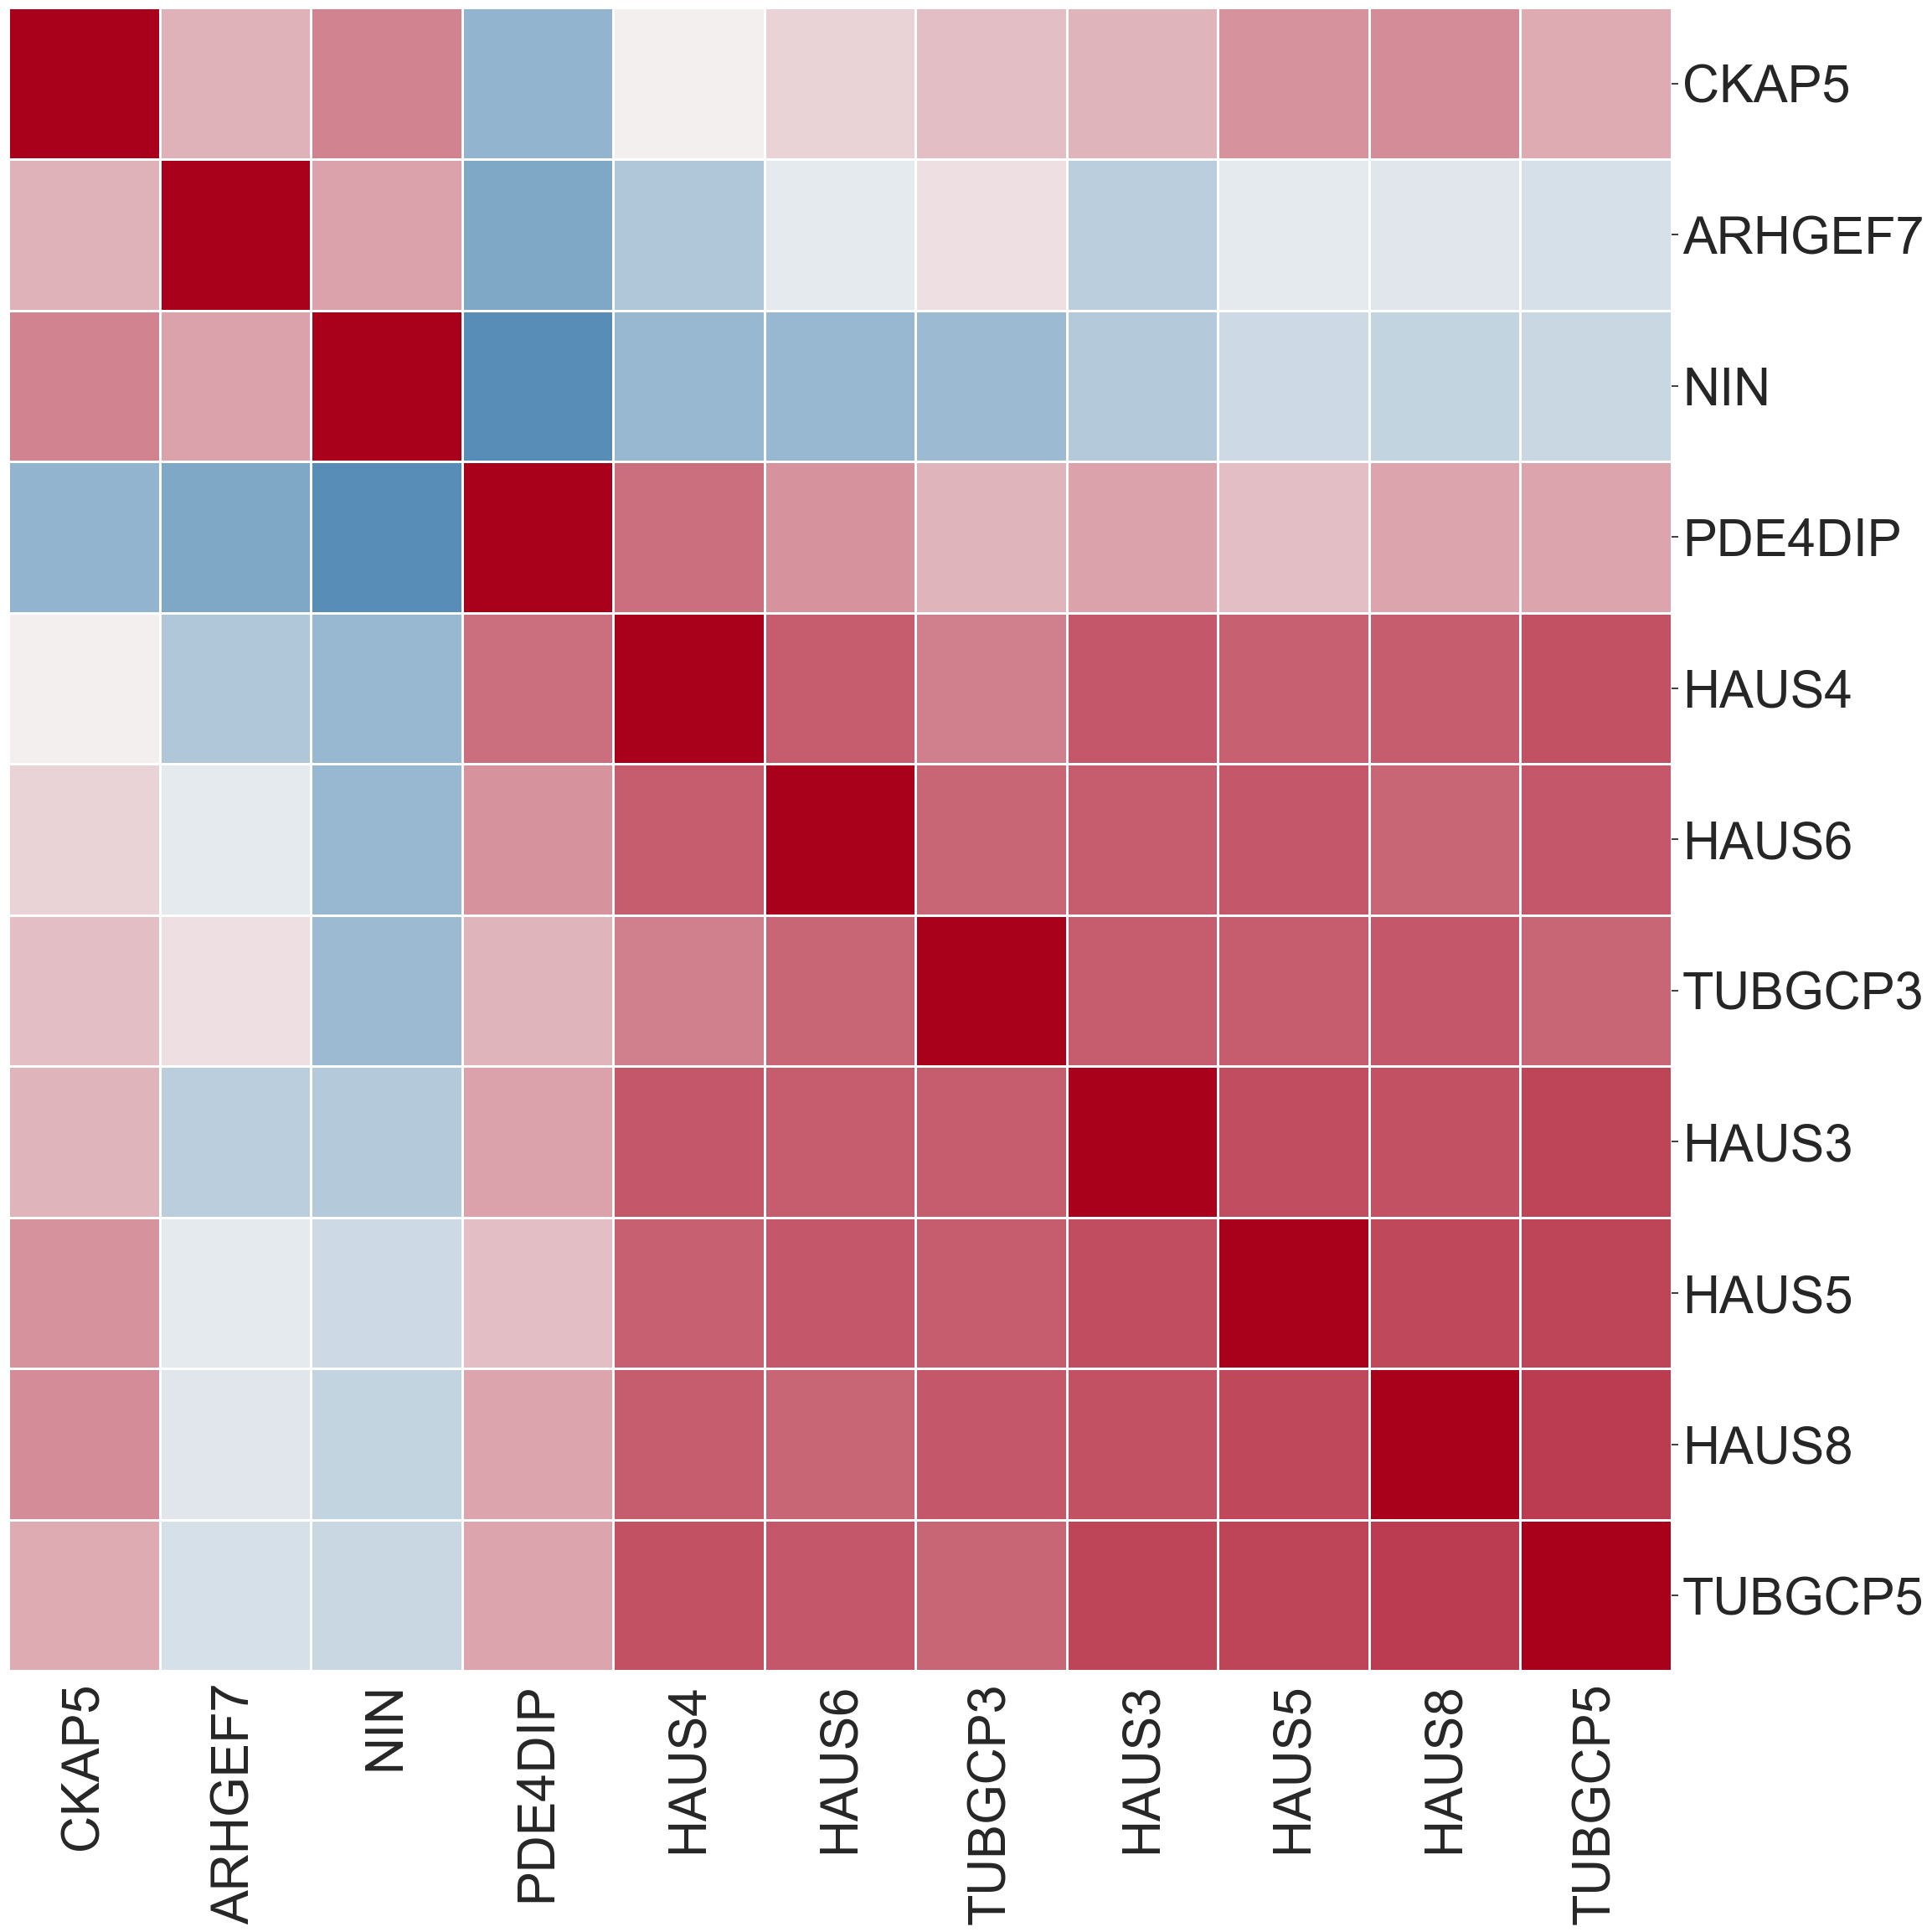

In [32]:
# Subset the geneset, calculate correlations, cluster and draw the heatmap
gene_set = 'Microtubule Nucleation'
genes_list = gene_set_dict[gene_set]
genes_list = [i for i in genes_list if i in hit_list]
genes_df =  df_gene_pca.loc[df_gene_pca.index.isin(genes_list)]

clustered_heat_map(genes_df.T,
                   os.path.join(output_folder,'figure_panels',f'Fig2G_{gene_set}_heat_map.png'),
                   4,0.8)


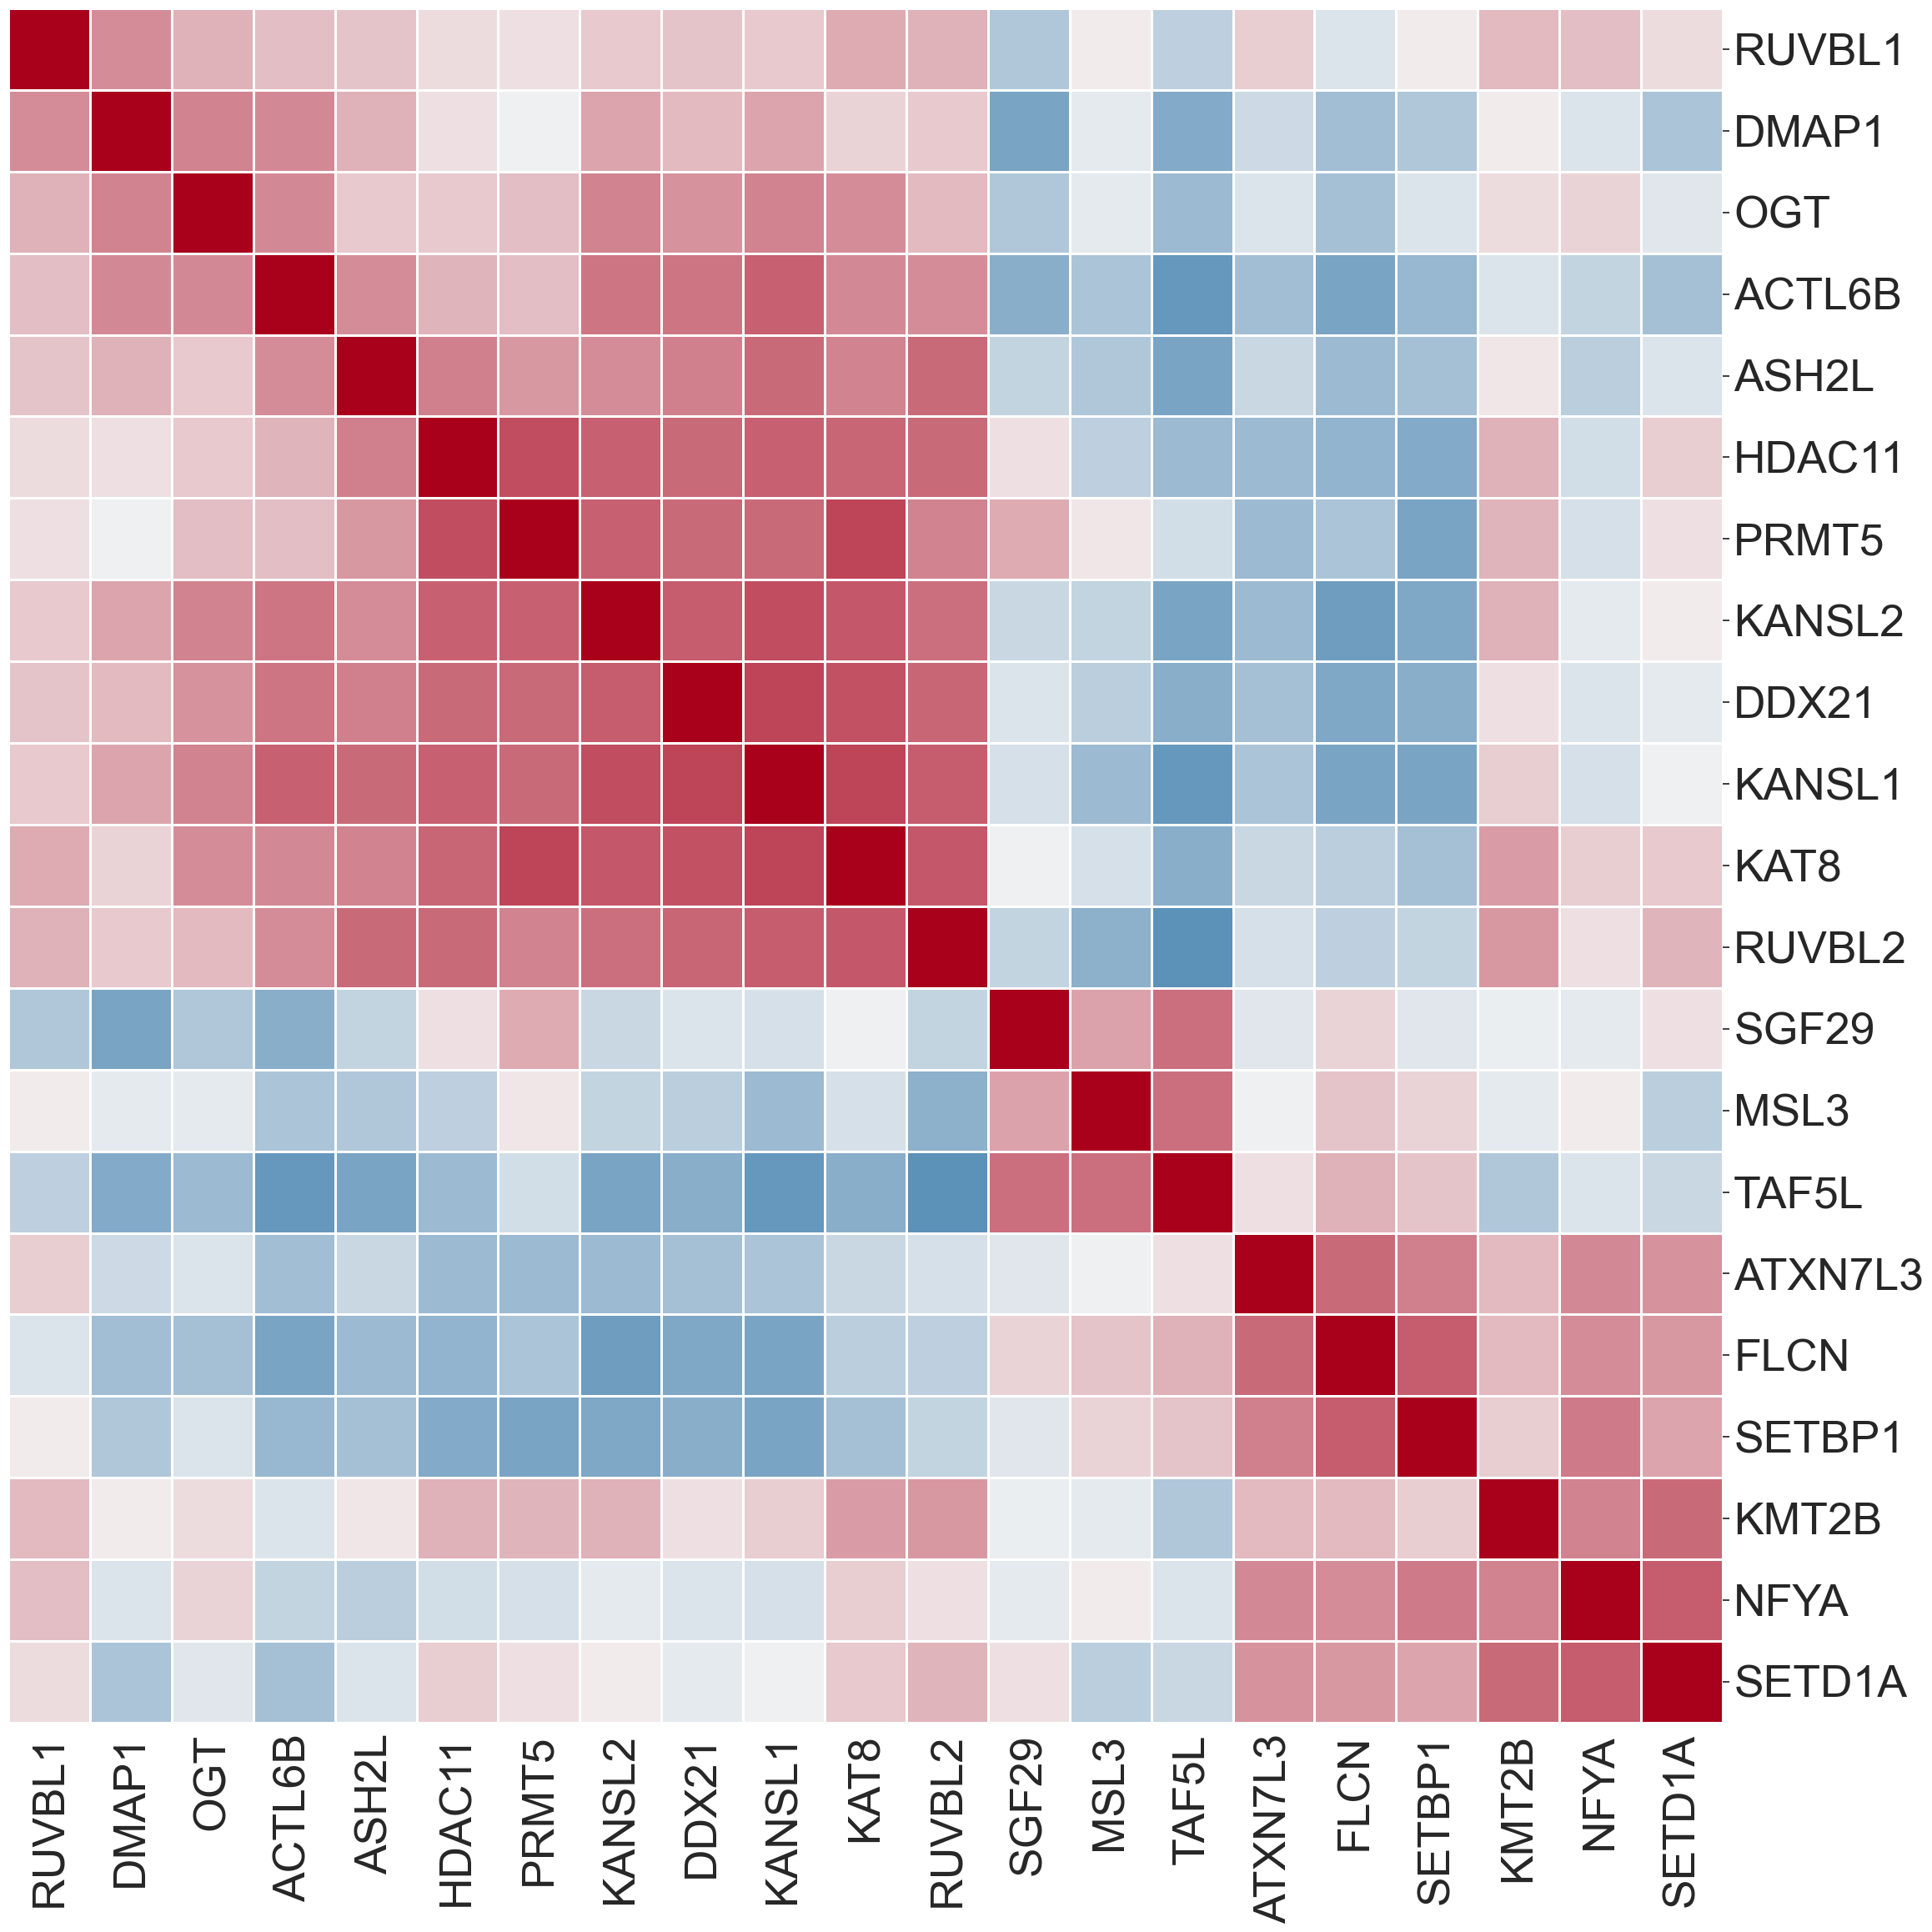

In [33]:
gene_set = 'Histone Modification'
genes_list = gene_set_dict[gene_set]
genes_list = [i for i in genes_list if i in hit_list]
genes_df =  df_gene_pca.loc[df_gene_pca.index.isin(genes_list)]

clustered_heat_map(genes_df.T,
                   os.path.join(output_folder,'figure_panels',f'Fig2G_{gene_set}_heat_map.png'),
                   3.5,0.8)